In [3]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher

In [4]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)

def category_label(val):
    category_label = None
    if val in ['I-3', 'I-4']:
        category_label = 'I'
    elif val in ['II-1', 'II-2', 'II-E']:
        category_label = 'II'
    elif val in ['III-1', 'III-2', 'III-E']:
        category_label = 'III'
    else:
        pass
        category_label = '0'
    return category_label

In [21]:
# Morbilidad B2
data = pd.read_pickle('data/morbilidad_b2.csv')
data['CATEGORY_GROUP'] = data['CATEGORY'].apply(lambda x : category_label(x))

data_lima_p = data[(data['STATE']=='LIMA')].reset_index(drop=True)
data_lima_m = data[(data['PROVINCE']=='LIMA') & (data['STATE']=='LIMA')].reset_index(drop=True)
del data


MemoryError: Unable to allocate 5.48 GiB for an array with shape (13, 56543263) and data type object

In [ ]:
data_lima_m.head()

### Outliers

### Number of diagnosis per month

In [ ]:
data_temp = data_lima_m.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp.head()

In [ ]:
#fig, ax = plt.subplots(2, 1, figsize=(10,7))
fig, ax = plt.subplots(2, 1, figsize=(17,7))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['sum'])
ax[0].bar(x, y, color='red')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served on Lima')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['count'])
ax[1].bar(x, y, color='blue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis on Lima')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

### Evolution of the top 10 diagnoses

In [9]:
PARAMETER = 'DISEASE'

data_temp = data_lima_m.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

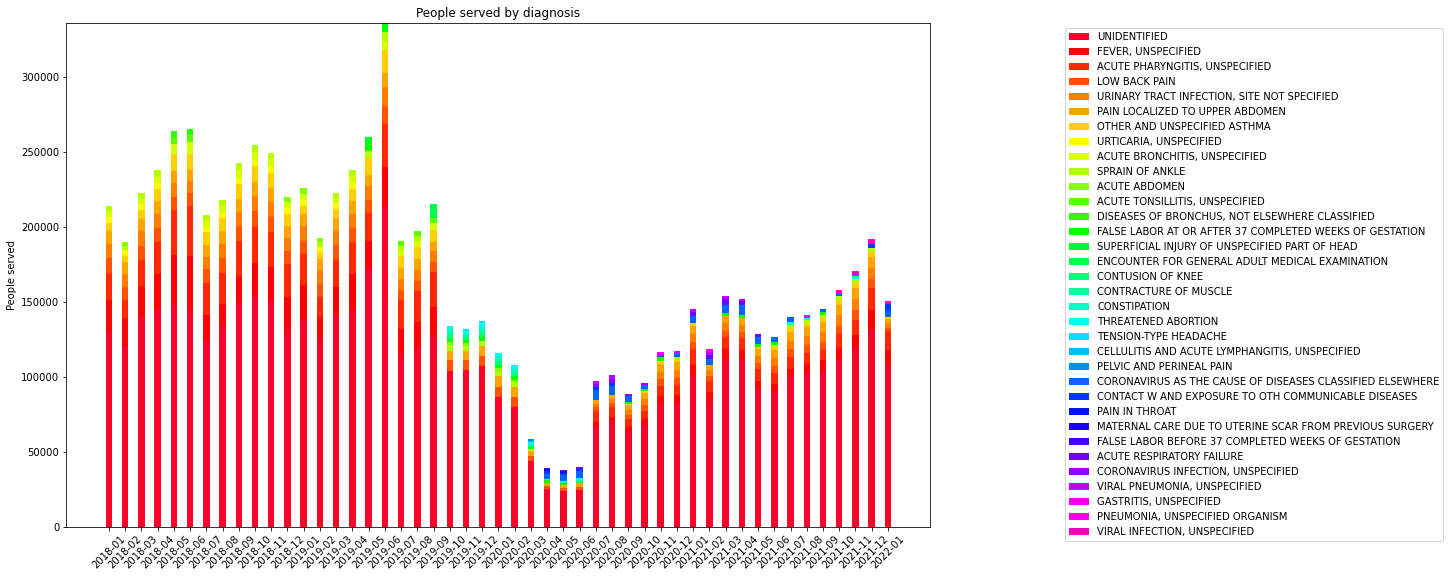

In [10]:

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

# Dignosis per year

In [11]:
data_temp = data_lima_m.groupby(['YEAR','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['YEAR']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp.head()

,YEAR,sum,count
0,2018,5245656,7141
1,2019,4681676,7010
2,2020,1897067,6390
3,2021,3327656,6780
4,2022,221752,3093


<ipython-input-12-90011594ab8d>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


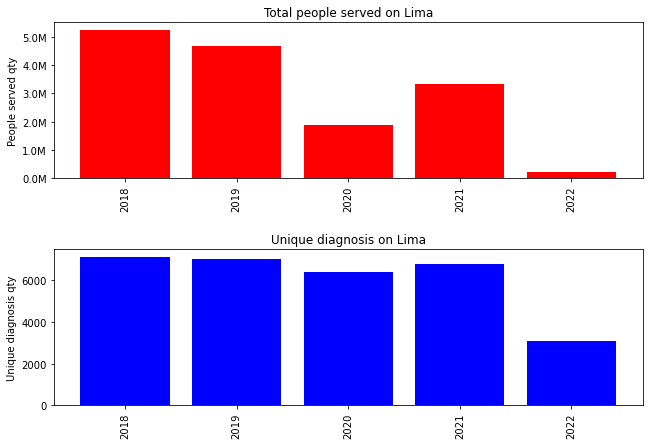

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10,7))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['YEAR'])]

y = list(data_temp['sum'])
ax[0].bar(x, y, color='red')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served on Lima')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['count'])
ax[1].bar(x, y, color='blue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis on Lima')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

### Evolution of the top 10 and 20 diagnoses

In [13]:
data_temp = data_lima_m.groupby(['YEAR','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
# data_temp = data_temp.reset_index()
# data_temp = data_temp.groupby(['YEAR']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp.head()

,YEAR,DISEASE,sum,count
0,2018,(IDIOPATHIC) NORMAL PRESSURE HYDROCEPHALUS,13,13
1,2018,(INDUCED) TERMINATION OF PREGNANCY W OTH AND U...,5,5
2,2018,4-AMINOPHENOL DERIVATIVES,8,8
3,2018,ABDOMINAL ACTINOMYCOSIS,3,3
4,2018,"ABDOMINAL AORTIC ANEURYSM, RUPTURED",4,4


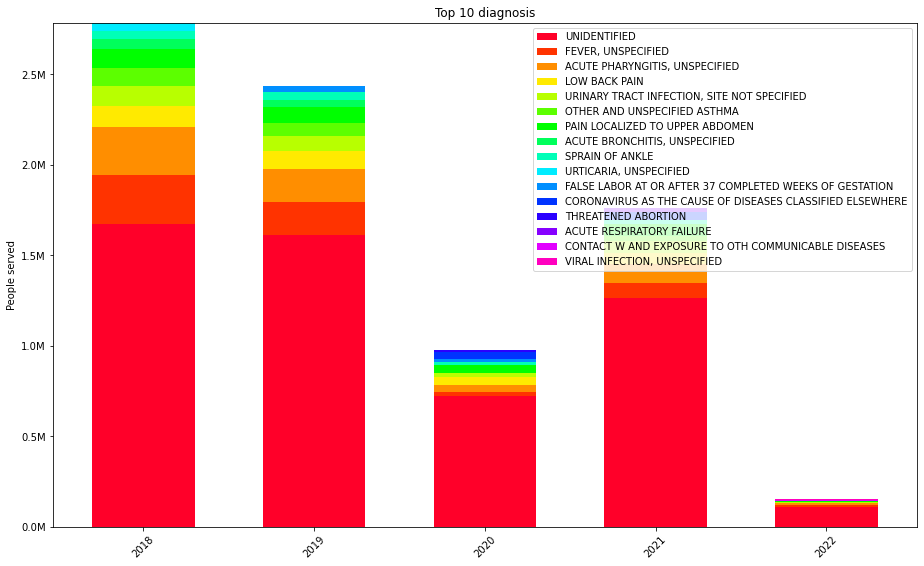

In [14]:
top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['YEAR'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    temp_df = temp_df.sort_values(by=['sum'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])

diagnosis = top_df['DISEASE'].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['YEAR']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['YEAR']=date
    temp_df['sum']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['YEAR', PARAMETER], ascending=True)

x_element = [str(item)[:7] for item in np.unique(top_df['YEAR'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.60

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['sum'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('Top 10 diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)


#ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))

ax.legend(labels=diagnosis)
plt.show()

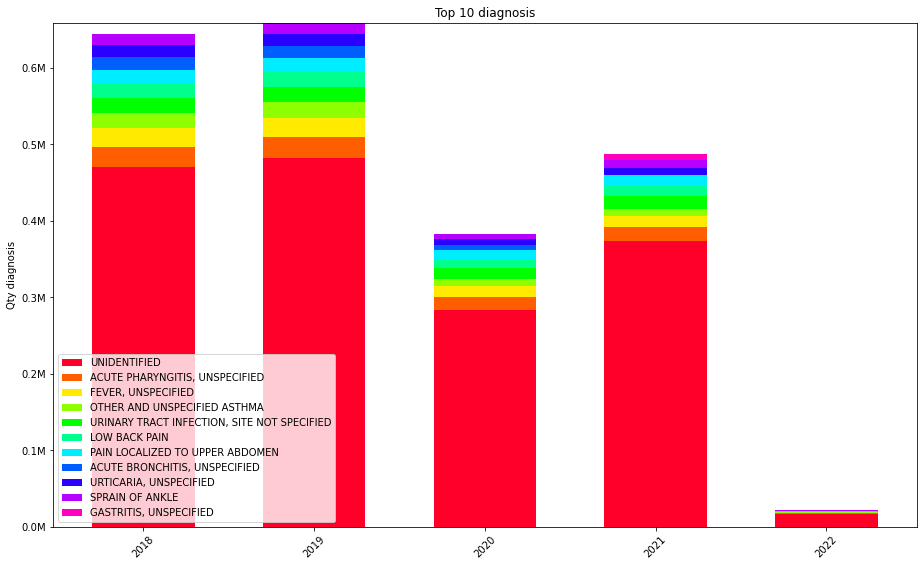

In [15]:
top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['YEAR'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    temp_df = temp_df.sort_values(by=['count'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])

diagnosis = top_df['DISEASE'].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['YEAR']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['YEAR']=date
    temp_df['count']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['YEAR', PARAMETER], ascending=True)

x_element = [str(item)[:7] for item in np.unique(top_df['YEAR'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.60

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['count'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('Qty diagnosis')
ax.set_title('Top 10 diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)


#ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))

ax.legend(labels=diagnosis)
plt.show()

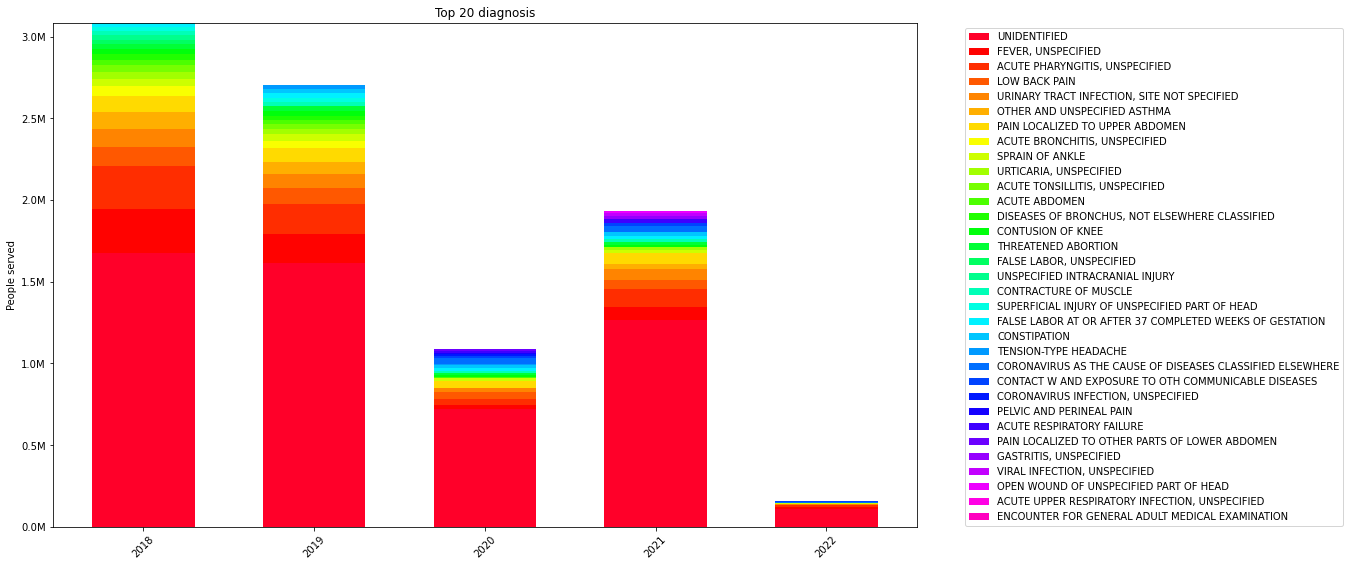

In [16]:
top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['YEAR'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    temp_df = temp_df.sort_values(by=['sum'], ascending=False)
    temp_df = temp_df.head(20).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])

diagnosis = top_df['DISEASE'].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['YEAR']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['YEAR']=date
    temp_df['sum']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['YEAR', PARAMETER], ascending=True)

x_element = [str(item)[:7] for item in np.unique(top_df['YEAR'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.60

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['sum'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('Top 20 diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)


ax.legend(labels=diagnosis, bbox_to_anchor = (1.05, 1))
#ax.legend(labels=diagnosis)
plt.show()

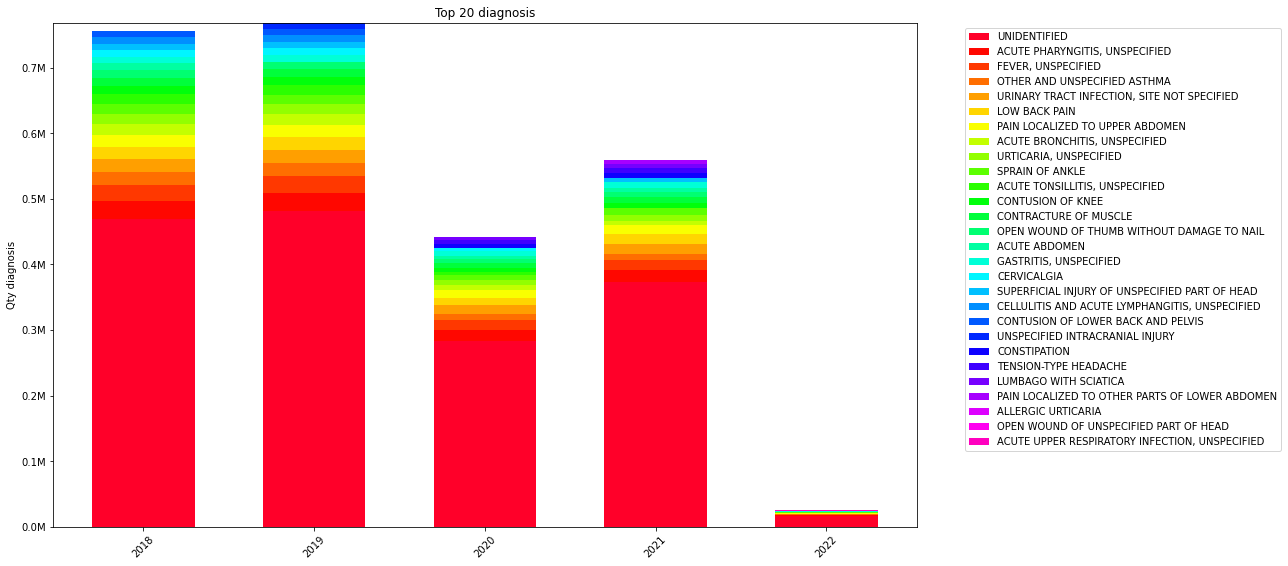

In [17]:
top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['YEAR'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    temp_df = temp_df.sort_values(by=['count'], ascending=False)
    temp_df = temp_df.head(20).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])

diagnosis = top_df['DISEASE'].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['YEAR']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['YEAR']=date
    temp_df['count']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['YEAR', PARAMETER], ascending=True)

x_element = [str(item)[:7] for item in np.unique(top_df['YEAR'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.60

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['count'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('Qty diagnosis')
ax.set_title('Top 20 diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)


ax.legend(labels=diagnosis, bbox_to_anchor = (1.05, 1))
#ax.legend(labels=diagnosis)
plt.show()

### Test if category zero dosen’t have cancer diagnostics or something like that 

<AxesSubplot:xlabel='YEAR,CATEGORY_GROUP'>

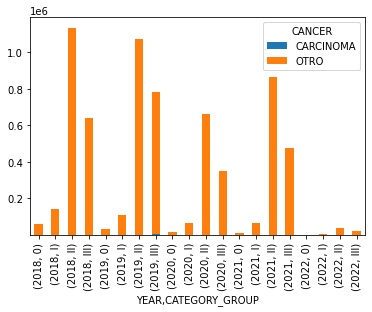

In [18]:
data_temp = data_lima_m[data_lima_m['CATEGORY_GROUP']=='0']
data_temp = data_lima_m.copy()
data_temp['CANCER'] = data_lima_m['DISEASE'].apply(lambda x : 'CARCINOMA' if 'CARCINOMA' in str(x) else 'OTRO')
#data_temp = data_temp.groupby(['YEAR','CATEGORY_GROUP','CANCER']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp = data_temp.groupby(['YEAR','CATEGORY_GROUP','CANCER']).agg({ 'QTY_PEOPLE_SERVED': 'count'})

data_temp = data_temp.sort_values(by=['YEAR','CATEGORY_GROUP']).reset_index()
data_temp = data_temp.pivot(index =['YEAR','CATEGORY_GROUP'], columns ='CANCER')
data_temp.columns = data_temp.columns.droplevel()
#data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)

data_temp.head()
data_temp.plot(kind="bar", stacked=True)

<ipython-input-19-a0bf0f2123b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['CANCER'] = data_temp['DISEASE'].apply(lambda x : 'CARCINOMA' if 'CARCINOMA' in str(x) else 'OTHERS')


<AxesSubplot:xlabel='YEAR,CATEGORY_GROUP'>

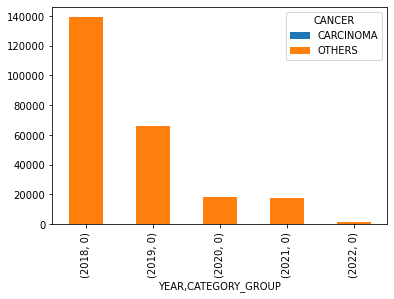

In [19]:
data_temp = data_lima_m[data_lima_m['CATEGORY_GROUP']=='0']
#data_temp = data_lima_m.copy()
data_temp['CANCER'] = data_temp['DISEASE'].apply(lambda x : 'CARCINOMA' if 'CARCINOMA' in str(x) else 'OTHERS')
#data_temp = data_temp.groupby(['YEAR','CATEGORY_GROUP','CANCER']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp = data_temp.groupby(['YEAR','CATEGORY_GROUP','CANCER']).agg({ 'QTY_PEOPLE_SERVED': 'sum'})

data_temp = data_temp.sort_values(by=['YEAR','CATEGORY_GROUP']).reset_index()
data_temp = data_temp.pivot(index =['YEAR','CATEGORY_GROUP'], columns ='CANCER')
data_temp.columns = data_temp.columns.droplevel()
#data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)

data_temp.head()
data_temp.plot(kind="bar", stacked=True)

In [20]:
data_temp

,CANCER,CARCINOMA,OTHERS
YEAR,CATEGORY_GROUP,,
2018,0,31.0,139372.0
2019,0,10.0,66091.0
2020,0,0.0,18061.0
2021,0,4.0,17285.0
2022,0,0.0,1411.0


In [ ]:
data_lima_m.head()